<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Linking linear diffusion and fluvial incision, using steady state hydrology

Versions of this model are common in the landscape evolution literature. Linear diffusion (e.g. Tucker and Bras, 1998, WRR, available <a href="http://onlinelibrary.wiley.com/doi/10.1029/98WR01474/full">here</a>) and detachment-limited incision (e.g. Howard, 1994, WRR, available <a href="http://onlinelibrary.wiley.com/doi/10.1029/94WR00757/full">here</a>) are operating everywhere on the landscape. Process competition leads to convex hillslopes at lower drainage area and concave channels at higher drainage area. Both of the suggested papers have great illustrations of these process interactions.

In this example, some illustrative things to change might be: 
  * hillslope diffusivity 
  * the stream-power coefficient and/or exponents 
  * uplift rate
  * the flow routing method
  * grid size
  * boundary conditions
  * your idea here!

#### Landlab Basics 
To use a Jupyter Notebook to run Landlab, first we import the libraries (code) we need from Landlab, as well as standard plotting functions and numpy.   <br/> 
In Landlab, processes are called components.<br/> 
Every component is a class. <br/> 
The grid is also a class.<br/>  

### Import Landlab and plotting libraries

In [1]:
from landlab.plot import imshow_grid
from landlab import RasterModelGrid, CLOSED_BOUNDARY, FIXED_VALUE_BOUNDARY
from landlab.components import FlowRouter, FastscapeEroder, LinearDiffuser
from matplotlib.pyplot import figure, show, plot, xlabel, ylabel, title
from matplotlib import pyplot as plt
%matplotlib inline 

import numpy as np

### Set up initial topography
* Instantiate a grid object, here we call it `mg`.

* Set the boundary conditions. In this case the top and bottom edges are fixed value, or open (water and sediment can pass out of the top and bottom boundaries). The right and left edges are closed.

* Make a rough surface as the initial topography.

* Make a plot to see the initial topography.

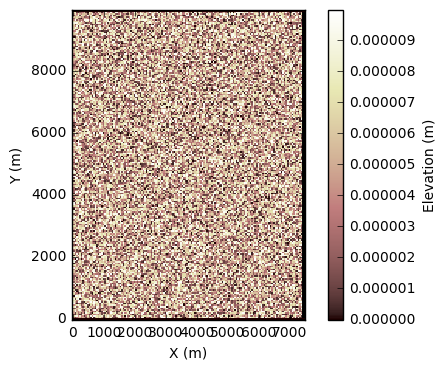

In [2]:
mg = RasterModelGrid((200, 150), 50.) # The grid is 200 rows by 100 columns, with dx = dy = 50 m.

for edge in (mg.nodes_at_left_edge, mg.nodes_at_right_edge):
             mg.status_at_node[edge] = CLOSED_BOUNDARY
for edge in (mg.nodes_at_top_edge, mg.nodes_at_bottom_edge):
             mg.status_at_node[edge] = FIXED_VALUE_BOUNDARY
        
z = mg.add_zeros('node', 'topographic__elevation')
initial_roughness = np.random.rand(mg.core_nodes.size)/100000.
mg.at_node['topographic__elevation'][mg.core_nodes] += initial_roughness

imshow_grid(mg, z, grid_units=['m','m'], var_name='Elevation (m)')  

### Intitalize time and uplift for the model run.

* Note that units are not imposed by many of the Landlab components, and the grid has no assumed units.
* In our case, with the `FastscapeEroder`, we just need to enter values with consistent units.
* For example, the grid was made with an assumed dx in meters. Time values are in years. So the erodibility coefficient in the `FastscapeEroder` should have units of meters and years.

In [3]:
total_t = 300000. # years
dt = 5000 # years
nt = int(total_t // dt) # number of time steps

uplift_rate = 0.001 # m/yr
uplift_per_step = uplift_rate * dt # depth (m) of uplift per timestep

### Instantiate the components for this model
In this case the difference components are:
  * `FlowRouter` which determines the drainage area at each point. In this case we are using `D8` to determine downslope neighbors.
  * `FastscapeEroder` which calculates the incision rate based on a power-law function of discharge and slope. This uses the Braun and Willet algorithm, reference <a href="http://www.sciencedirect.com/science/article/pii/S0169555X12004618">here</a>)
  * `LinearDiffusers` which calculates erosion and deposition of material using a sediment transport rate which is proportional to the slope. Here we do not allow diffusion to deposit, but you can change that.
  * Note that in the case of `FastscapeEroder`, the values are noted when the class is instantiated. In the case of the `LinearDiffuser`, the value is assigned to a variable and that variable is sent to the class. There are multiple ways to do things, depending on your coding style and what makes sense to you.

In [4]:
fr = FlowRouter(mg, method='D8')
sp = FastscapeEroder(mg, K_sp=0.00005, m_sp=0.5, n_sp=1.0, threshold_sp=0.,
                    rainfall_intensity=1.)
                    
k_d = 0.5
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=k_d )

* The calculations are all done in the time loop below.

In [5]:
for i in range(nt):
    fr.run_one_step() # route flow
    sp.run_one_step(dt) # fluvial incision
    lin_diffuse.run_one_step(dt) # linear diffusion
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    
    if i % 20 == 0:
      print ("Completed loop ", i, " out of ", nt)

('Completed loop ', 0, ' out of ', 60)
('Completed loop ', 20, ' out of ', 60)
('Completed loop ', 40, ' out of ', 60)


### Visualize the results.
  * First we plot the topography after the time loop.
  * Second we plot the slope-area relationship, which is often used to identify hillslopes, channels, and quantify drainage density.

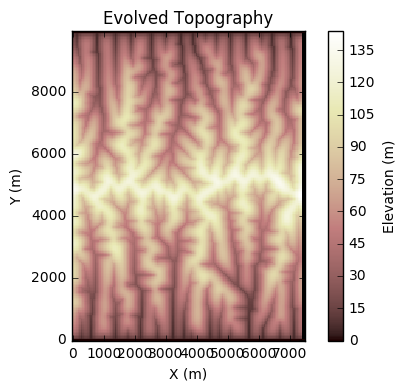

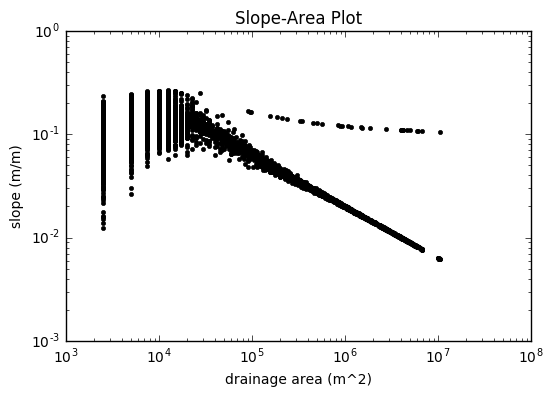

In [6]:
plt.figure(1)    
imshow_grid(mg, 'topographic__elevation', grid_units=['m','m'], var_name='Elevation (m)')
plt.title('Evolved Topography')
plt.show()
plt.figure(2)
plt.loglog(mg.at_node['drainage_area'][mg.core_nodes],mg.at_node['topographic__steepest_slope'][mg.core_nodes],'k.')
plt.xlabel('drainage area (m^2)')
plt.ylabel('slope (m/m)')
plt.title('Slope-Area Plot')
plt.show()

### Edit the model and rerun it. 
* Remember if you edit any of the code, you need to re-run the edited code block.
* If you re-run the time loop, it will operate on the existing topography. If you want to start over on a flat surface, then you need to re-run the code block that instantiated the grid.